In [1]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import matplotlib as plt
import os

In [2]:
os.chdir("/home/matvey/data/LshCas13a_RNA_cleavage/LshCas13a_in_vitro_total_RNA/")

In [3]:
LRTTableFile = "Results/Tables/TCS_detection_tables/LRTest_table_and_genome_features.tsv"
EcoliChrFile = "Reference_sequences/NC_000913.3.fasta"
RNAFragmentsOutputFile = "hairpin_cleavage/Results/top_10_ORFs_cleaved_RNA_fragments.fasta"
NormCountsTableFile = "Results/Tables/Merged_ends_counts/N5E_T_vs_NT_CPM_normalized.tsv.gz"

In [4]:
LRTTable = pd.read_csv(LRTTableFile, sep="\t")
LRTTable.sort_values(by="PValue.adj", ascending=True, inplace=True, ignore_index=True)
EcoliChrSeq = SeqIO.read(EcoliChrFile, "fasta").seq.transcribe()

NormCountsTable = pd.read_csv(NormCountsTableFile, sep="\t")

In [5]:
def extract_adj_seqs(seq, pos, strand, width):
    assert (strand in ["+", "-"]), "Invalid strand value"
    #should be 0-based coordinates
    if strand == "+":
        seq_slice = seq[pos-width : pos+width]
    elif strand == "-":
        seq_slice = seq[pos-width+1 : pos+width+1].reverse_complement()
    return(seq_slice)

In [6]:
Width = 50
SubSeqsList = list()

for i, row in LRTTable[LRTTable["MatchedFeatureType"] == "CDS"].head(10).iterrows():
    record_id = f'{row["MatchedFeatureGene"]}-{row["Pos"]}-({row["Strand"]})'
    record_seq = extract_adj_seqs(seq=EcoliChrSeq,
                                  pos=row["Pos"]-1,
                                  strand=row["Strand"],
                                  width=Width)
    
    SubSeqsList.append(SeqRecord(id=record_id,
                                 name=record_id,
                                 description=f'{row["MatchedFeatureDescription"]} fragment', 
                                 seq=record_seq))

In [7]:
with open(RNAFragmentsOutputFile, "w") as hOutput:
    SeqIO.write(sequences=SubSeqsList, handle=hOutput, format="fasta")

In [8]:
from subprocess import Popen, PIPE
import forgi, re
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np

In [9]:
DotBracketNotationFile = "hairpin_cleavage/Results/top_10_ORFs_cleaved_RNA_fragments.dbn"

In [10]:
energy_pattern = r"\((.\d+.+)\)"
with open(DotBracketNotationFile, "w") as hDotBracketNotationFile:
    RNAfoldProc = Popen(["RNAfold", "--noPS", RNAFragmentsOutputFile], stdout=PIPE)
    
    for line in RNAfoldProc.stdout:
        hDotBracketNotationFile.write(re.sub(energy_pattern, "", line.decode("ascii")))

In [11]:
ForgiSSRecordsColorsAnnotated = list()

In [12]:
def get_colors_array(Table, SeqID, pos, strand, width):
    if strand == "+":
        pos_array = np.arange(pos-width, pos+width)
        TableSubset = Table[(Table["SeqID"] == SeqID) & (Table["Strand"] == strand) & (Table["Pos"].isin(pos_array))]
        TableSubset_sorted = TableSubset.sort_values(by="Pos", ascending=True, ignore_index=True)
        logFC_values = TableSubset_sorted["aveLogFC"].tolist()
        
    elif strand == "-":
        pos_array = np.arange(pos-width+1, pos+width+1)
        TableSubset = Table[(Table["SeqID"] == SeqID) & (Table["Strand"] == strand) & (Table["Pos"].isin(pos_array))]
        TableSubset_sorted = TableSubset.sort_values(by="Pos", ascending=False, ignore_index=True)
        logFC_values = TableSubset_sorted["aveLogFC"].tolist()
    
    cmap = cm.Reds
    norm = colors.Normalize(vmin=min(logFC_values), vmax=max(logFC_values))
    colors_array = [cmap(norm(x)) for x in logFC_values]
    
    return(colors_array)

(<AxesSubplot:>,
 array([[ 7.80739288e+01,  3.59454163e+02],
        [ 6.42744522e+01,  3.66550232e+02],
        [ 4.89446602e+01,  3.64146667e+02],
        [ 3.79791718e+01,  3.53167694e+02],
        [ 3.55944481e+01,  3.37834961e+02],
        [ 4.27074547e+01,  3.24044220e+02],
        [ 5.65830994e+01,  3.17098267e+02],
        [ 5.89065704e+01,  3.02279327e+02],
        [ 5.67956581e+01,  2.95056458e+02],
        [ 6.15396538e+01,  2.87038544e+02],
        [ 6.43228683e+01,  2.72299011e+02],
        [ 6.71060867e+01,  2.57559479e+02],
        [ 5.70482979e+01,  2.44181137e+02],
        [ 5.97467499e+01,  2.27322998e+02],
        [ 7.40280304e+01,  2.17368698e+02],
        [ 7.63515015e+01,  2.02549744e+02],
        [ 7.06790161e+01,  1.88777588e+02],
        [ 8.04605560e+01,  1.76342468e+02],
        [ 8.27840271e+01,  1.61523514e+02],
        [ 7.71115417e+01,  1.47751358e+02],
        [ 8.68930817e+01,  1.35316238e+02],
        [ 8.92165527e+01,  1.20497284e+02],
        [ 9.154

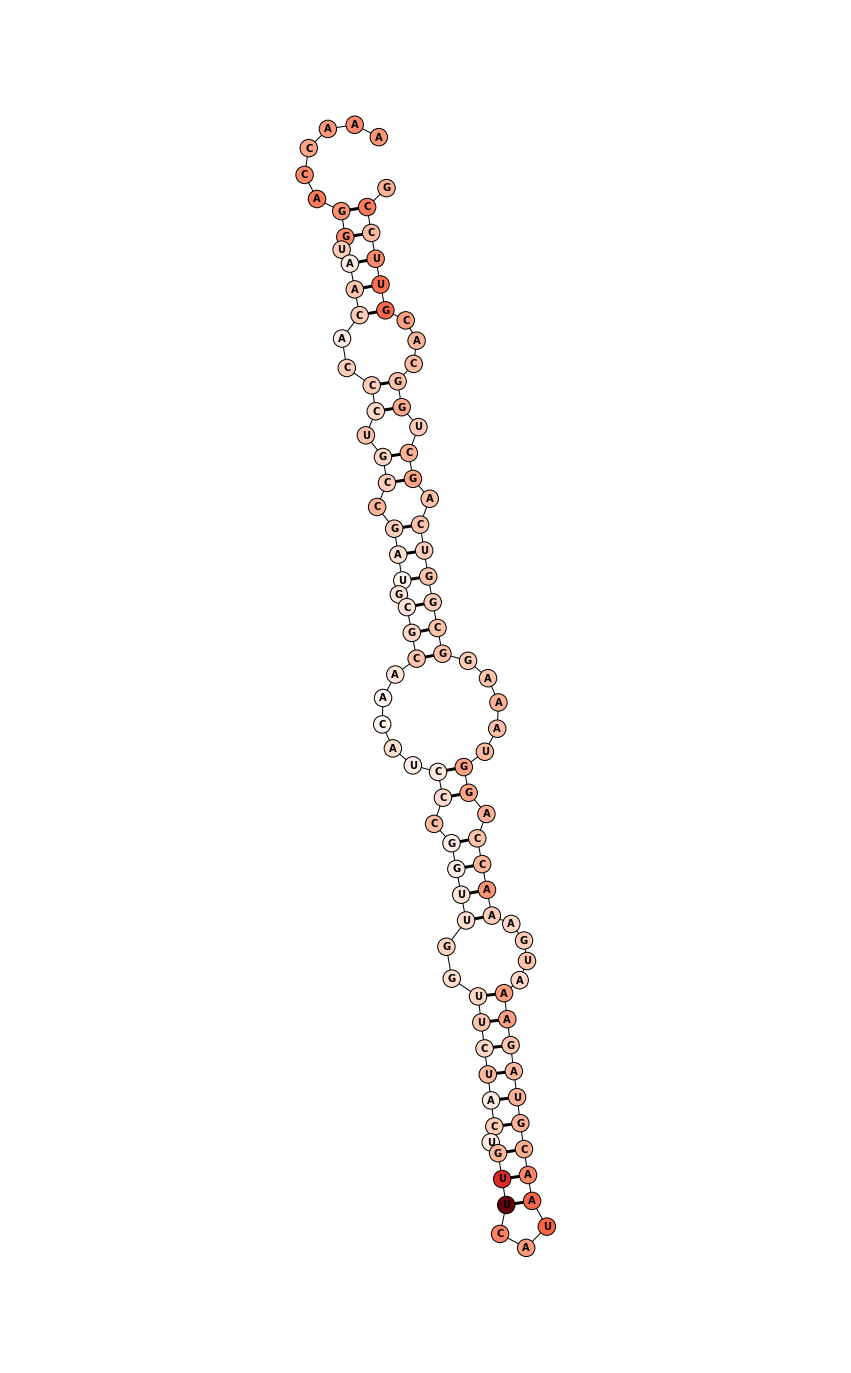

In [15]:
from mplotlib_addcolors import plot_rna_addcolors
figure, ax = plt.subplots(figsize=(15, 25))
plot_rna_addcolors(ForgiSSRecords[0], 
                   ax=ax, 
                   text_kwargs={"fontweight":"black"}, 
                   lighten=0, 
                   backbone_kwargs={"linewidth":1}, 
                   colorlist=a, annotations=None)

In [ ]:
LRTTable

In [14]:
a = get_colors_array(Table=NormCountsTable, SeqID="NC_000913.3", pos=696906, strand="-", width=50)